# Import Libraries

All library imports are done in here

In [2]:
# Built-in Library Imports
import os
import requests

from itertools import islice
from time import sleep

# Base Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.base import BaseEstimator
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, mean_squared_error, root_mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Sklearn Model Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

# Dotenv Import, allowing the use of .env files.
from dotenv import load_dotenv
load_dotenv()

True

# Variables

All global variables are to be defined in this section.

In [3]:
dataPath = "./datapack"
"""
Defines the folder path where the data is stored. This variable should not be changed as it is
used to locate the data for the project. If there are user-provided data that will be used, these
data must be stored in the folder defined by this variable.

:default: "./datapack"
"""

outputPath = "./output"
"""
Defines the folder path where the output files are stored. This variable should not be changed as it
is used to locate the output files for the project. If there are any output files that will be generated
from the project, these files must be stored in the folder defined by this variable.
"""

defaultTrainData = f"{dataPath}/spotify_songs.csv"
"""
The `defaultTrainData` variable contains the default path to the training data. This is used
when the user does not provide a path to the training data. The path is relative to the root
directory of the project and must remain so.

:default: "./datapath/spotify_songs.csv"
"""

trainData = defaultTrainData
"""
The `trainData` variable contains the path to the training data. This variable is used to store
any user-provided data that will be used for training the model. If the user does not provide
a path to the training data, the `defaultTrainData` variable is used instead.

:default: "./datapath/spotify_songs.csv"
"""

indexes = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]
"""
Contains all the indexes that are used for the audio features. These indexes are the `x`
values for the model.
"""

audioFeatures = ['track_popularity'] + indexes
"""
The `audioFeatures` list contains all the audio features that are used for training the model.
This includes the entire `indexes` list while the `track_popularity` is added to the list but
is not included in the `indexes` list. This is because the `track_popularity` is the `y` value
for the model.
"""

'\nThe `audioFeatures` list contains all the audio features that are used for training the model.\nThis includes the entire `indexes` list while the `track_popularity` is added to the list but\nis not included in the `indexes` list. This is because the `track_popularity` is the `y` value\nfor the model.\n'

# Functions

All functions to define are done in this section. This section is divided into two categories:

- [API Functions](#api-functions)
- [Model Functions](#model-functions)
- [Project Functions](#project-functions)

## API Functions

All API related functions are created in this category, such as the `getToken` function where it fetches the user's access token by feeding it the `CLIENT_ID` and `CLIENT_SECRET` tokens.

In [4]:
def getToken() -> str:
    """
    Fetches the user's `ACCESS_TOKEN` by sending a POST request to Spotify's API.
    Access token is required to make requests to Spotify's API.
    To be able to get the token, you need to have a `CLIENT_ID` and `CLIENT_SECRET`
    which can be obtained by creating a Spotify Developer account, which will then be
    put in a `.env` file in the root directory of the project.
    
    :return str: The access token of the user.
    :raises Exception: If the request does not return a status code of 200.
    """

    url = "https://accounts.spotify.com/api/token"
    header = {"Content-type": "application/x-www-form-urlencoded"}
    data = {
        "grant_type": "client_credentials",
        "client_id": os.getenv("CLIENT_ID"),
        "client_secret": os.getenv("CLIENT_SECRET")
    }

	# Send request to get token
    res = requests.post(
        url,
        headers = header,
        data = data
    )

    if res.status_code == 429:
        print(res)
        raise Exception(f"getToken: Rate Limit Exceeded, try again in {res.headers.get('Retry-After', 1)} seconds")
    # if request does not return 200, raise exception
    elif res.status_code != 200:
        raise Exception("getToken: ", res.text)

    # Example Output: 'BQCq8oiJHxi.....iv_5sAuoF1YwhQADyc'
    return res.json()['access_token']

# ==================================================================================================== #

def getAudioFeatures(trackID: str) -> dict:
    """
    Fetches the audio features of a track by sending a GET request to Spotify's API.
    
    The audio features include the following:
    - **`acousticness`** [0.0 - 1.0] -      A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
    - **`analysis_url`** [string] -         An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.
    - **`danceability`** [0.0 - 1.0] -      Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
    - **`duration_ms`** [int] -             The duration of the track in milliseconds.
    - **`energy`** [0.0 - 1.0] -            Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
    - **`id`** [string] -                   The Spotify ID for the track.
    - **`instrumentalness`** [0.0 - 1.0] -  Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
    - **`key`** [int] -                     The key the track is in. Integers map to pitches using standard [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class). E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
    - **`liveness`** [0.0 - 1.0] -          Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
    - **`loudness`** [-60.0 - 0.0] -        The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
    - **`mode`** [int] -                    Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
    - **`speechiness`** [0.0 - 1.0] -       Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music.
    - **`tempo`** [float] -                 The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
    - **`time_signature`** [int] -          An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
    - **`track_href`** [string] -           A link to the Web API endpoint providing full details of the track.
    - **`type`** [string] -                 The object type: “audio_features”
    - **`uri`** [string] -                  The Spotify URI for the track.
    - **`valence`** [0.0 - 1.0] -           A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
    
    :param trackID: The Spotify ID for the track. (Example: "06AKEBrKUckW0KREUWRnvT")
    :type trackID: str
    
    :return dict: The audio features of the track.
    """
    url = "https://api.spotify.com/v1/audio-features/" + trackID
    header = {"Authorization": "Bearer " + getToken() }
    res = requests.get(
        url,
        headers = header
    )

    if res.status_code == 429:
        print(res)
        raise Exception("getToken: Rate Limit Exceeded")
    elif res.status_code != 200:
        raise Exception(f"getAF: {res.json()["error"]["message"]}")
    
    return res.json()

# ==================================================================================================== #

def getPopularity(trackID: str, multiple: bool = False) -> int:
    """
    Fetches the popularity of a track by sending a GET request to Spotify's API.
    
    :param trackID: The Spotify ID for the track. (Example: `"09o4dR4x2Sx6wjv4u5xdux"`)
    :type trackID: str
    
    :param multiple: Whether the provided `trackID` is a list of track IDs or not. (Default: `False`)
    :type multiple: bool
    
    :return int | dict: The popularity of the track. If `multiple` is set to `True`, a dictionary with the track IDs as the keys and the popularity as the values will be returned.
    """
    
    url = f"https://api.spotify.com/v1/tracks{"?ids=" if multiple else "/"}{trackID}"
    header = {"Authorization": "Bearer " + getToken() }
    res = requests.get(
        url,
        headers = header
    )
    
    if res.status_code == 429:
        print(res)
        raise Exception("getToken: Rate Limit Exceeded")
    elif res.status_code != 200:
        raise Exception(f"getPopularity: {res.json()["error"]["message"]}")
    
    if multiple:
        toRet = {}
        for track in res.json()['tracks']:
            toRet[track['id']] = track['popularity']
        return toRet
    else:
        return res.json()['popularity']

# ==================================================================================================== #

def getName(trackID: str, withArtist: bool = False, multiple: bool = False) -> str:
    """
    Fetches the name of a track by sending a GET request to Spotify's API.
    
    :param trackID: The Spotify ID for the track. (Example: `"09o4dR4x2Sx6wjv4u5xdux"` => `"Kekkon Koushinkyoku"`)
    :type trackID: str
    
    :param withArtist: Whether to include the artist of the track in the output. (Default: `False`)
    :type withArtist: bool
    
    :param multiple: Whether the provided `trackID` is a list of track IDs or not. (Default: `False`)
    :type multiple: bool
    
    :return str: The name of the track. If `withArtist` is set to `True`, the name of the track and the artist will be included in the output. And if `multiple` is set to `True`, a dictionary with the track IDs as the keys and the names as the values will be returned.
    """
    
    url = f"https://api.spotify.com/v1/tracks{"?ids=" if multiple else "/"}{trackID}"
    header = {"Authorization": "Bearer " + getToken() }
    res = requests.get(
        url,
        headers = header
    )
    
    if res.status_code == 429:
        print(res)
        raise Exception("getToken: Rate Limit Exceeded")
    elif res.status_code != 200:
        raise Exception(f"getName: {res.json()["error"]["message"]}")
    
    if multiple:
        toRet = {}
        for track in res.json()['tracks']:
            toRet[track['id']] = track['name'] + (" (" + track['artists'][0]['name'] + ")" if withArtist else "")
        return toRet
    else:
        return res.json()['name'] + (" (" + res.json()['artists'][0]['name'] + ")" if withArtist else "")

# ==================================================================================================== #

def getSongData(trackID: str, withName: bool = False, asDataFrame: bool = False, multiple: bool = False) -> dict | list | pd.DataFrame:
    """
    Fetches the audio features and popularity of a track by sending a GET request to Spotify's API.
    
    If `withName` is set to `True`, the name of the track and the artist will be included in the
    output, allowing for easier identification of the track. The format of the output will be a list
    with the first element being the audio features and popularity of the track, and the second element
    being the name of the track and the artist.
    
    :param trackID: The Spotify ID for the track. (Example: `"09o4dR4x2Sx6wjv4u5xdux"` => `"Kekkon Koushinkyoku"`)
    :type trackID: str
    
    :param withName: Whether to include the name of the track and the artist in the output. (Default: `False`)
    :type withName: bool
    
    :param asDataFrame: Whether to return the data as a `DataFrame` or not. (Defaults: `False`)
    :type asDataFrame: bool
    
    :param multiple: Whether the provided `trackID` is a list of track IDs or not. (Default: `False`)
    :type multiple: bool
    
    :return dict | list | pd.DataFrame: The audio features and popularity of the track. If `withName` is set to `True`, the name of the track and the artist will be included in the output.
    """
    songData = None
    if multiple:
        for id in trackID.split(","):
            songData = getAudioFeatures(id)
            sleep(1)
    else:
        songData = getAudioFeatures(trackID)
    
    songData['track_popularity'] = getPopularity(trackID, multiple = multiple)
    
    needed = ["track_popularity"] + indexes
    name = None
    
    if (withName):
        name = getName(trackID, withArtist = True, multiple = multiple)
    
    for key in list(songData.keys()):
        if key not in needed:
            del songData[key]
    
    if (asDataFrame):
        songData = pd.DataFrame(songData, index = [0])
    
    return songData if not withName else (songData, name)

## Model Functions

All functions relating to training a model can be defined here. This separation from [Project Functions](#project-functions) allows organization of codes and a non-cluttered workspace.

In [5]:
def trainDecisionTree(xTrain, yTrain, criterion = "squared_error", folds = 5) -> DecisionTreeRegressor:
    """
    Trains a Decision Tree model using the given data.
    
    ## See:
    - [DecisionTreeRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param criterion: The function to measure the quality of a split. (Default: "squared_error")
    :type criterion: {"squared_error", "absolute_error", "friedman_mse", "poisson"}, default = "squared_error"
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int
    
    :return DecisionTreeRegressor: The trained Decision Tree model.
    """
    model = DecisionTreeRegressor(criterion = criterion)
    model.fit(xTrain, yTrain)

    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Decision Tree Regressor Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    return model

# ==================================================================================================== #

def trainRandomForest(xTrain, yTrain, criterion = "squared_error", folds = 5) -> RandomForestRegressor:
    """
    Trains a Random Forest model using the given data.
    
    ## See:
    - [RandomForestRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param criterion: The function to measure the quality of a split. (Default: "squared_error")
    :type criterion: {"squared_error", "absolute_error", "friedman_mse", "poisson"}, default = "squared_error"
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int, default = 5
    
    :return RandomForestRegressor: The trained Random Forest model.
    """
    model = RandomForestRegressor(criterion = criterion)
    model.fit(xTrain, yTrain)

    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Random Forest Regressor Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    return model

# ==================================================================================================== #

def trainLogisticRegression(xTrain, yTrain, folds = 5) -> LogisticRegression:
    """
    Trains a Logistic Regression model using the given data.
    
    ## See:
    - [LogisticRegression](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int
    
    :return LogisticRegression: The trained Logistic Regression model.
    """
    model = LogisticRegression()
    model.fit(xTrain, yTrain)

    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Logistic Regression Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    return model

# ==================================================================================================== #

def trainLinearRegression(xTrain, yTrain, folds = 5) -> LinearRegression:
    """
    Trains a Linear Regression model using the given data.
    
    ## See:
    - [LinearRegression](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LinearRegression.html)
    - [KFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    
    :param xTrain: The training data.
    :type xTrain: numpy.ndarray
    
    :param yTrain: The target data.
    :type yTrain: numpy.ndarray
    
    :param folds: The number of folds to use for cross-validation. (Default: 5)
    :type folds: int
    
    :return LinearRegression: The trained Linear Regression model.
    """
    model = LinearRegression()
    model.fit(xTrain, yTrain)
    
    kFolds = KFold(n_splits = folds)
    scores = cross_val_score(model, xTrain, yTrain, cv = kFolds)
    print(f"Linear Regression Score: {scores}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    return model

## Project Functions

All project related functions are created in this category, such as the `importData` function where it imports a `csv` or any excel file types and returns them as a data frame.

In [6]:
def importData(path: str) -> pd.DataFrame:
    """
    Imports the data from the specified path and returns it as a DataFrame.
    
    :param path: The path of the file to be imported.
    :type path: str
    
    :return pd.DataFrame: The data in the form of a DataFrame.
    """
    
    acceptedFormats = ["xls", "xlsx", "xlsm", "xlsb", "odf", "ods", "odt"]
    
    if path.endswith(".csv"):
        return pd.read_csv(path)
    else:
        for format in acceptedFormats:
            if path.endswith(format):
                return pd.read_excel(path)

# ==================================================================================================== #

def splitData(dataSet: pd.DataFrame, yCol: str, scaler: any = False, testSize: float = 0.2, toDrop: list = []) -> list:
    """
    Splits the dataset into training and testing data. Changes to the dataset are not made in place, allowing the original dataset to be preserved.
    This function also scales the data if a scaler is provided. However, the scaler must be initialized before passing it to the function and the
    scaler must be able to perform the `fit_transform` and `transform` methods. These scalers are usually from the `sklearn.preprocessing` module.
    Using other scalers may result in an error.
    
    If the `testSize` is set to `0`, the function will not split the data and will return the entire dataset as the training data. This is useful
    when the dataset is to be used for training only and not for testing. All processes will still be done as usual, but the testing data will return
    an empty DataFrame.
    
    The function returns a list containing the training and testing data. Training data is stored under the key `train` and testing data is
    stored under the key `test` in the form of a dictionary, and each of these dictionaries contain the keys `x` and `y` which represent the features
    and labels respectively. If the data is to be extracted, it can be done as follows:

    ```python
    trainData, testData = splitData(dataSet, yCol, scaler, testSize, toDrop)
    ```
    
    :param dataSet: The dataset to be split.
    :type dataSet: pd.DataFrame
    
    :param yCol: The column to be predicted.
    :type yCol: str
    
    :param scaler: The scaler to be used to scale the data. Default is `False`.
    :type scaler: any
    
    :param testSize: The size of the test data. Default is `0.2`, which is 20%.
    :type testSize: float
    
    :param toDrop: The columns to be dropped from the dataset. Default is `[]`.
    :type toDrop: list
    
    :return list: A list containing the training and testing data.
    """
    dataSet = dataSet.copy()
    
    if len(toDrop) > 0:
        dataSet.drop(toDrop, axis = 1, inplace = True)
    
    x = dataSet.drop(yCol, axis = 1)
    y = dataSet[yCol]

    train = {}
    test = {} 

    if testSize != 0:
        train['x'], test['x'], train['y'], test['y'] = train_test_split(x, y, test_size = testSize)
    else:
        train['x'], train['y'] = x, y
        test['x'], test['y'] = pd.DataFrame(), pd.DataFrame()

    if (scaler != False) and (scaler != None):
        train['x'] = scaler.fit_transform(train['x'])
        if testSize != 0:
            test['x'] = scaler.transform(test['x'])

    return train, test

# ==================================================================================================== #

def selectFeatures(xTrain, yTrain, columns, useRF = True, criterion = "squared_error", printReport = True) -> pd.DataFrame:
    """
    Uses a Decision Tree or Random Forest Regressor to select the most important features from the dataset. The function returns a DataFrame
    containing the feature importances of each feature in the dataset. The feature importances are calculated using the `feature_importances_`
    attribute of the regressor. The function also prints a classification report if `printReport` is set to `True`.
    
    The features can be deemed important if they have a high feature importance value. If the feature importance value is low, the feature may
    not be important and can be removed from the dataset. The feature importance values can be used to determine the most important features
    in the dataset.
    
    Removing features can be done as follows:
    ```python
    featureImportances = selectFeatures(xTrain, yTrain, columns)
    xTrain = xTrain.loc[:, featureImportances['rfc'] > 0.1]
    
    # OR IF USING A DECISION TREE
    xTrain = xTrain.loc[:, featureImportances['dt'] > 0.1]
    ```
    
    :param xTrain: The training data.
    :type xTrain: pd.DataFrame
    
    :param yTrain: The labels.
    :type yTrain: pd.DataFrame
    
    :param columns: The columns of the dataset.
    :type columns: list
    
    :param useRF: Whether to use a Random Forest Regressor or a Decision Tree Regressor. Default is `True`.
    :type useRF: bool
    
    :param criterion: The function to measure the quality of a split. (Default: "squared_error")
    :type criterion: {"squared_error", "absolute_error", "friedman_mse", "poisson"}, default = "squared_error"
    
    :param printReport: Whether to print the RMSE report. Default is `True`.
    :type printReport: bool
    
    :return pd.DataFrame: A DataFrame containing the feature importances of each feature in the dataset. If `useRF` is set to `True`, the column name would be `rfc`, otherwise it will be `dt`.
    """
    
    if useRF:
        featureSelector = trainRandomForest(xTrain, yTrain, criterion)
    else:
        featureSelector = trainDecisionTree(xTrain, yTrain, criterion)

    yPred = featureSelector.predict(xTrain)

    if printReport:
        print(root_mean_squared_error(yTrain, yPred))

    return pd.DataFrame(
        {f'{"rfc" if useRF else "dt"}': featureSelector.feature_importances_},
        index = columns
    )

# ==================================================================================================== #

def selectFeaturesRFE(estimator: BaseEstimator, xTest, yTest, printReport = True) -> list:
    """
    Using the Recursive Feature Elimination (RFE) method, the function selects the most important features from the dataset. The function prints
    the support, ranking, and classification report if `printReport` is set to `True`.
    
    The function returns a list containing the support and ranking of the features. The support is a boolean array of the features selected and the
    ranking is an array of the ranking of the features. The features with the lowest ranking are the most important while the features with the
    highest ranking are the least important. On the other hand, the features with a support of `True` are selected while the features with a support
    of `False` are not selected.
    
    If features are to be removed, they can be done as follows:
        
    ```python
    support, ranking = selectFeaturesRFE(estimator, xTest, yTest)
    xTrain = xTrain.loc[:, support]
    
    # OR
    xTrain = xTrain.loc[:, ranking < 3]
    ```
    
    :param estimator: The estimator to be used by the RFE.
    :type estimator: BaseEstimator
    
    :param xTest: The testing data.
    :type xTest: pd.DataFrame
    
    :param yTest: The labels.
    :type yTest: pd.DataFrame
    
    :param printReport: Whether to print the classification report. Default is `True`.
    :type printReport: bool
    
    :return list: A list containing the support and ranking of the features.
    """
    rfe = RFE(estimator = estimator)
    rfe.fit(xTest, yTest)
    
    if printReport:
        print(f"Support: {rfe.support_}\n")
        print(f"Ranking: {rfe.ranking_}\n")
        print(f"RMSE Report:\n")
        print(root_mean_squared_error(yTest, rfe.predict(xTest)))

    return rfe.support_, rfe.ranking_

# ==================================================================================================== #

def intersection(list1, list2) -> list:
    """
    Creates a new list containing the intersection of the two lists provided.
    """
    return list(set(list1) & set(list2))

# ==================================================================================================== #

def chunkList(lst: list, chunkSize: int) -> list:
    """
    Chunks a list into smaller lists of the specified size.
    
    :param list: The list to be chunked.
    :type list: list
    
    :param chunkSize: The size of the chunks.
    :type chunkSize: int
    
    :return list: A list of chunks.
    """
    it = iter(lst)
    return iter(lambda: tuple(islice(it, chunkSize)), ())

# ==================================================================================================== #

def stop():
    """
    Stops the execution of the program by raising an exception. This could be useful when
    the program needs to be stopped at a certain point without killing the kernel.
    """
    raise Exception("Program Stopped")

# Import Training Data

In [7]:
rawTrainDf = importData(trainData)
rawTrainDf.head(10)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052
5,7fvUMiyapMsRRxr07cU8Ef,Beautiful People (feat. Khalid) - Jack Wins Remix,Ed Sheeran,67,2yiy9cd2QktrNvWC2EUi0k,Beautiful People (feat. Khalid) [Jack Wins Remix],2019-07-11,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,8,-5.385,1,0.1270,0.0799,0.000000,0.1430,0.585,124.982,163049
6,2OAylPUDDfwRGfe0lYqlCQ,Never Really Over - R3HAB Remix,Katy Perry,62,7INHYSeusaFlyrHSNxm8qH,Never Really Over (R3HAB Remix),2019-07-26,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,5,-4.788,0,0.0623,0.1870,0.000000,0.1760,0.152,112.648,187675
7,6b1RNvAcJjQH73eZO4BLAB,Post Malone (feat. RANI) - GATTÜSO Remix,Sam Feldt,69,6703SRPsLkS4bPtMFFJes1,Post Malone (feat. RANI) [GATTÜSO Remix],2019-08-29,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,4,-2.419,0,0.0434,0.0335,0.000005,0.1110,0.367,127.936,207619
8,7bF6tCO3gFb8INrEDcjNT5,Tough Love - Tiësto Remix / Radio Edit,Avicii,68,7CvAfGvq4RlIwEbT9o8Iav,Tough Love (Tiësto Remix),2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,8,-3.562,1,0.0565,0.0249,0.000004,0.6370,0.366,127.015,193187
9,1IXGILkPm0tOCNeq00kCPa,If I Can't Have You - Gryffin Remix,Shawn Mendes,67,4QxzbfSsVryEQwvPFEV5Iu,If I Can't Have You (Gryffin Remix),2019-06-20,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,2,-4.552,1,0.0320,0.0567,0.000000,0.0919,0.590,124.957,253040


# Data Pre-Processing

Feature engineering, processing, and cleaning.

### Drop all NA values

Drops all rows with empty values.

In [8]:
# drop any rows with missing value from any column, 
# axis 0 to drop the rows not the columns

trainDf = rawTrainDf.dropna(how='any', axis=0)
trainDf.isnull().sum()

track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

### Feature Engineering

Modify the features to make them viable for fitting down the road.

#### Playlist Genre

In [17]:
trainDf['playlist_genre'].unique()

array(['pop', 'rap', 'rock', 'latin', 'r&b', 'edm'], dtype=object)

#### Playlist Subgenre

In [18]:
trainDf['playlist_subgenre'].unique()

array(['dance pop', 'post-teen pop', 'electropop', 'indie poptimism',
       'hip hop', 'southern hip hop', 'gangster rap', 'trap',
       'album rock', 'classic rock', 'permanent wave', 'hard rock',
       'tropical', 'latin pop', 'reggaeton', 'latin hip hop',
       'urban contemporary', 'hip pop', 'new jack swing', 'neo soul',
       'electro house', 'big room', 'pop edm',
       'progressive electro house'], dtype=object)

#### Fractional undersampling

undersampling technique with significant number of lowlevel popularity level....
run this to perform fractional undersampling 

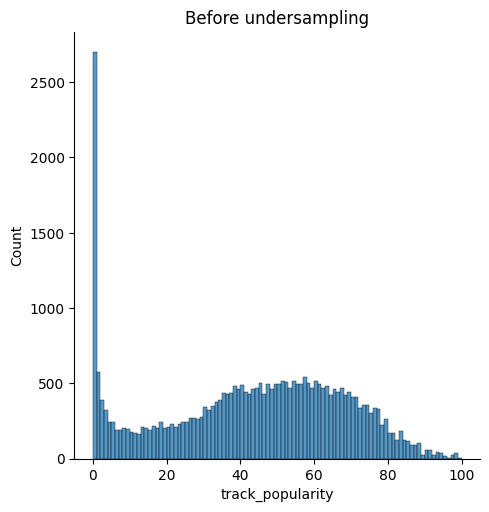

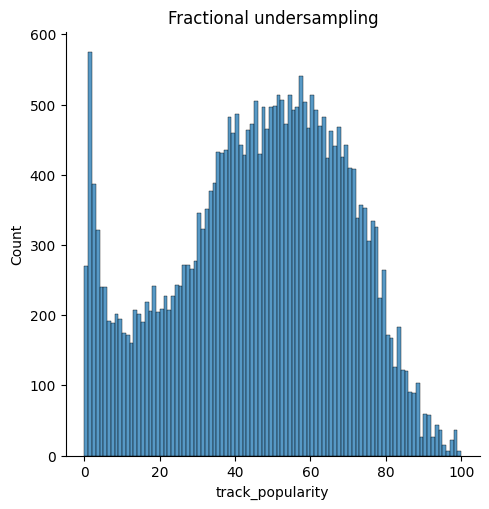

In [28]:
# output the distribution
import seaborn as sns
trainDf = rawTrainDf.dropna(how='any', axis=0)
# BEFORE
sns.displot(trainDf, x="track_popularity", bins=100)
plt.xlabel('track_popularity')
plt.ylabel('Count')
plt.title('Before undersampling')
plt.show()


# separate 0 and non 0 pop level
trainDf_zero = trainDf[trainDf['track_popularity'] == 0]
trainDf_nonZero = trainDf[trainDf['track_popularity'] > 0]

# Undersampling technique: Random undersampling with fractional sampling
trainDf_zero = trainDf_zero.sample(frac=0.1)

# fuse
trainDf = pd.concat([trainDf_zero, trainDf_nonZero])
sns.displot(trainDf, x="track_popularity", bins=100)
plt.xlabel('track_popularity')
plt.ylabel('Count')
plt.title('Fractional undersampling')
plt.show()







#### Multiple Fractional Undersampling

undersampling technique with few number of lowlevel popularity level....
run this to perform multi fractional undersampling 


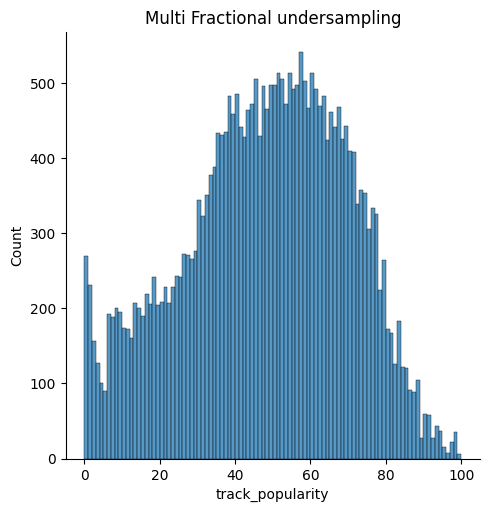

In [26]:
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler


trainDf = rawTrainDf.dropna(how='any', axis=0)
# BEFORE
# sns.displot(trainDf, x="track_popularity", bins=100)
# plt.xlabel('track_popularity')
# plt.ylabel('Count')
# plt.title('Before undersampling')
# plt.show()


# Separate low popularity (0-5) and other tracks
popularity_0 = trainDf[trainDf['track_popularity'] == 0]
popularity_1_5 = trainDf[(trainDf['track_popularity'] > 0) & (trainDf['track_popularity'] <= 5)]
popularity_6_100 = trainDf[trainDf['track_popularity'] > 5]

# Apply fractional undersampling with different fractions for each range
popularity_0 = popularity_0.sample(frac=0.1)  # Keep n% of zero-popularity tracks
popularity_1_5 = popularity_1_5.sample(frac=0.4)  # Keep n% of low-popularity tracks

# Concatenate the subsets to get the balanced data
trainDf = pd.concat([popularity_0, popularity_1_5, popularity_6_100])

# Plot the result
sns.displot(trainDf, x="track_popularity", bins=100)
plt.xlabel('track_popularity')
plt.ylabel('Count')
plt.title('Multi Fractional undersampling')
plt.show()


#### Remove Features

Removes all features that aren't in the `audioFeatures` list.

In [ ]:
trainDf = trainDf[trainDf.columns.intersection(audioFeatures)]
trainDf.head(5)

# Data Analytics

In [ ]:
trainDf.describe().transpose()

## Correlation

Check the correlation of each features.

### Data Frame Correlation Method

Using the `.corr()` function, visualize the correlation heatmap of each features.

In [12]:
correlation = trainDf.corr()
plt.figure(figsize=(10,9))
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap")
plt.show()

NameError: name 'trainDf' is not defined

### Random Forest Correlation

Using a Random Forest Regressor, check and visualize the correlation of features against the `track_popularity` feature.

In [11]:
rfTrain, rfTest = splitData(trainDf, 'track_popularity', scaler = StandardScaler())

featureFrameRF = selectFeatures(rfTrain['x'], rfTrain['y'], indexes, useRF = True)
featureFrameRF.sort_values(by = 'rfc', ascending = True, inplace = True)

indexRF = np.arange(len(featureFrameRF))
figRF, axRF = plt.subplots(figsize = (10, 7))
selectedFeaturesRF = axRF.barh(indexRF, featureFrameRF['rfc'], 0.5, color = 'blue', label = 'Feature Importance (Random Forest)')
axRF.set(yticks = indexRF, yticklabels = featureFrameRF.index)

axRF.legend()
plt.show()

NameError: name 'trainDf' is not defined

### Decision Tree Correlation

Using a Decision Tree, check and visualize the correlation of features against the `track_popularity` feature.

In [ ]:
dtTrain, dtTest = splitData(trainDf, 'track_popularity', scaler = StandardScaler())

featureFrameDT = selectFeatures(dtTrain['x'], dtTrain['y'], indexes, useRF = False)
featureFrameDT.sort_values(by = 'dt', ascending = True, inplace = True)

indexDT = np.arange(len(featureFrameDT))
figDT, axDT = plt.subplots(figsize = (10, 7))
selectedFeaturesDT = axDT.barh(indexDT, featureFrameDT['dt'], 0.5, color = 'blue', label = 'Feature Importance (Decision Tree)')
axDT.set(yticks = indexDT, yticklabels = featureFrameDT.index)

axDT.legend()
plt.show()

### Recursive Feature Elimination

Using an RFE, check the ranking of each feature to identify which features to use.

In [16]:
rfeTrain = dict()
rfeTest = dict()
featureFrameRFE = {
    "rf": {
        "support": None,
        "ranking": None,
        "featureRanking": dict(),
        "featureSupport": dict()
    },
    "dt": {
        "support": None,
        "ranking": None,
        "featureRanking": dict(),
        "featureSupport": dict()
    },
    "lr": {
        "support": None,
        "ranking": None,
        "featureRanking": dict(),
        "featureSupport": dict()
    }
}

# Random Forest Regressor
rfeTrain['rf'], rfeTest['rf'] = splitData(trainDf, 'track_popularity', scaler = StandardScaler())
# Decision Tree Regressor
rfeTrain['dt'], rfeTest['dt'] = splitData(trainDf, 'track_popularity', scaler = StandardScaler())
# Logistic Regression
rfeTrain['lr'], rfeTest['lr'] = splitData(trainDf, 'track_popularity', scaler = StandardScaler())

#### Random Forest for RFE

Using Random Forest for RFE.

In [ ]:
# Random Forests only
featureFrameRFE['rf']['support'], featureFrameRFE['rf']['ranking'] = selectFeaturesRFE(RandomForestRegressor(), rfeTrain['rf']['x'], rfeTrain['rf']['y'])

# Sort the features based on their ranking
for i in range(len(featureFrameRFE['rf']['ranking'])):
    featureFrameRFE['rf']['featureRanking'][indexes[i]] = int(featureFrameRFE['rf']['ranking'][i])
featureFrameRFE['rf']['featureRanking'] = {k: v for k, v in sorted(featureFrameRFE['rf']['featureRanking'].items(), key = lambda item: item[1], reverse = True)}

# Sort the features based on their support
for i in range(len(featureFrameRFE['rf']['support'])):
    featureFrameRFE['rf']['featureSupport'][indexes[i]] = bool(featureFrameRFE['rf']['support'][i])
featureFrameRFE['rf']['featureSupport'] = {k: v for k, v in sorted(featureFrameRFE['rf']['featureSupport'].items(), key = lambda item: item[1], reverse = True)}

print("RFE with Random Forest Regressor")
print(featureFrameRFE['rf']['featureRanking'])
print(featureFrameRFE['rf']['featureSupport'])

# Create a horizontal bar graph
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(featureFrameRFE['rf']['featureRanking'])), featureFrameRFE['rf']['featureRanking'].values(), color='blue')
plt.yticks(np.arange(len(featureFrameRFE['rf']['featureRanking'])), featureFrameRFE['rf']['featureRanking'].keys())
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking using RFE with Random Forest')
plt.show()


#### Decision Tree for RFE

Using Decision Tree for RFE.

In [ ]:
# Decision Tree only
featureFrameRFE['dt']['support'], featureFrameRFE['dt']['ranking'] = selectFeaturesRFE(DecisionTreeRegressor(), rfeTrain['dt']['x'], rfeTrain['dt']['y'])

# Sort the features based on their ranking
for i in range(len(featureFrameRFE['dt']['ranking'])):
    featureFrameRFE['dt']['featureRanking'][indexes[i]] = int(featureFrameRFE['dt']['ranking'][i])
featureFrameRFE['dt']['featureRanking'] = {k: v for k, v in sorted(featureFrameRFE['dt']['featureRanking'].items(), key = lambda item: item[1], reverse = True)}

# Sort the features based on their support
for i in range(len(featureFrameRFE['dt']['support'])):
    featureFrameRFE['dt']['featureSupport'][indexes[i]] = bool(featureFrameRFE['dt']['support'][i])
featureFrameRFE['dt']['featureSupport'] = {k: v for k, v in sorted(featureFrameRFE['dt']['featureSupport'].items(), key = lambda item: item[1], reverse = True)}

print("RFE with Decision Tree Regressor")
print(featureFrameRFE['dt']['featureRanking'])
print(featureFrameRFE['dt']['featureSupport'])

# Create a horizontal bar graph
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(featureFrameRFE['dt']['featureRanking'])), featureFrameRFE['dt']['featureRanking'].values(), color='blue')
plt.yticks(np.arange(len(featureFrameRFE['dt']['featureRanking'])), featureFrameRFE['dt']['featureRanking'].keys())
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking using RFE with Decision Tree')
plt.show()


#### Logistic Regression for RFE

Using Logistic Regression for RFE.

In [ ]:
# Random Forests only
featureFrameRFE['lr']['support'], featureFrameRFE['lr']['ranking'] = selectFeaturesRFE(LogisticRegression(), rfeTrain['lr']['x'], rfeTrain['lr']['y'])

# Sort the features based on their ranking
for i in range(len(featureFrameRFE['lr']['ranking'])):
    featureFrameRFE['lr']['featureRanking'][indexes[i]] = int(featureFrameRFE['lr']['ranking'][i])
featureFrameRFE['lr']['featureRanking'] = {k: v for k, v in sorted(featureFrameRFE['lr']['featureRanking'].items(), key = lambda item: item[1], reverse = True)}

# Sort the features based on their support
for i in range(len(featureFrameRFE['lr']['support'])):
    featureFrameRFE['lr']['featureSupport'][indexes[i]] = bool(featureFrameRFE['lr']['support'][i])
featureFrameRFE['lr']['featureSupport'] = {k: v for k, v in sorted(featureFrameRFE['lr']['featureSupport'].items(), key = lambda item: item[1], reverse = True)}

print("RFE with Logistic Regression")
print(featureFrameRFE['lr']['featureRanking'])
print(featureFrameRFE['lr']['featureSupport'])

# Create a horizontal bar graph
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(featureFrameRFE['lr']['featureRanking'])), featureFrameRFE['lr']['featureRanking'].values(), color='blue')
plt.yticks(np.arange(len(featureFrameRFE['lr']['featureRanking'])), featureFrameRFE['lr']['featureRanking'].keys())
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking using RFE with Logistic Regression')
plt.show()


## Comparison

Compare all results and see the most relevant features.

In [ ]:
trainDfMod = trainDf.drop('track_popularity', axis = 1)
print(f"Original columns ({len(trainDfMod.columns)}):\n{trainDfMod.columns}")

In [ ]:
# Random Forest Regressor
tdmRF = trainDfMod.loc[:,featureFrameRF['rfc'] > 0.1]
print(f"Random Forest Regressor ({len(tdmRF.columns)}):\n{tdmRF.columns}\n")

# Decision Tree Regressor
tdmDT = trainDfMod.loc[:,featureFrameDT['dt'] > 0.1]
print(f"Decision Tree Regressor ({len(tdmDT.columns)}):\n{tdmDT.columns}\n")

# Recursive Feature Elimination with Random Forest Regressor
tdmRFERFSup = trainDfMod.loc[:, featureFrameRFE['rf']['support']]
print(f"Recursive Feature Elimination [Random Forest - Support] ({len(tdmRFERFSup.columns)}):\n{tdmRFERFSup.columns}\n")

tdmRFERFRan = trainDfMod.loc[:, featureFrameRFE['rf']['ranking'] < 2]
print(f"Recursive Feature Elimination [Random Forest - Ranking] ({len(tdmRFERFRan.columns)}):\n{tdmRFERFRan.columns}\n")

# Recursive Feature Elimination with Decision Tree Regressor
tdmRFEDTSup = trainDfMod.loc[:, featureFrameRFE['dt']['support']]
print(f"Recursive Feature Elimination [Decision Tree - Support] ({len(tdmRFEDTSup.columns)}):\n{tdmRFEDTSup.columns}\n")

tdmRFEDTRan = trainDfMod.loc[:, featureFrameRFE['dt']['ranking'] < 2]
print(f"Recursive Feature Elimination [Decision Tree - Ranking] ({len(tdmRFEDTRan.columns)}):\n{tdmRFEDTRan.columns}\n")

# Recursive Feature Elimination with Logistic Regression
tdmRFELRSup = trainDfMod.loc[:, featureFrameRFE['lr']['support']]
print(f"Recursive Feature Elimination [Logistic Regression - Support] ({len(tdmRFELRSup.columns)}):\n{tdmRFELRSup.columns}\n")

tdmRFELRRan = trainDfMod.loc[:, featureFrameRFE['lr']['ranking'] < 2]
print(f"Recursive Feature Elimination [Logistic Regression - Ranking] ({len(tdmRFELRRan.columns)}):\n{tdmRFELRRan.columns}\n")

### Intersection

In [ ]:
selectedFeaturesIntersection = intersection(
    tdmRF.columns,
    intersection(
        tdmDT.columns,
        intersection(
            tdmRFERFSup.columns,
            intersection(
                tdmRFERFRan.columns,
                intersection(
                    tdmRFEDTSup.columns,
                    intersection(
                        tdmRFEDTRan.columns,
                        intersection(
                            tdmRFELRSup.columns,
                            tdmRFELRRan.columns
                        )
                    )
                )
            )
        )
    )
)

selectedFeaturesIntersection

### Frequency

In [23]:
selectedFeaturesFrequency = dict()
currentlySelectedFeatures = [tdmRF, tdmDT, tdmRFERFSup, tdmRFERFRan, tdmRFEDTSup, tdmRFEDTRan, tdmRFELRSup, tdmRFELRRan]

In [ ]:
for features in currentlySelectedFeatures:
    for feature in features.columns:
        if feature in selectedFeaturesFrequency:
            selectedFeaturesFrequency[feature] += 1
        else:
            selectedFeaturesFrequency[feature] = 1

selectedFeaturesFrequency = {k: v for k, v in sorted(selectedFeaturesFrequency.items(), key = lambda item: item[1], reverse = True)}
selectedFeaturesFrequency

#### Frequency Bar Graph

In [ ]:
plt.figure(figsize=(10, 7))
plt.barh(np.arange(len(selectedFeaturesFrequency)), selectedFeaturesFrequency.values(), color='blue')
plt.yticks(np.arange(len(selectedFeaturesFrequency)), selectedFeaturesFrequency.keys())
plt.xlabel('Frequency')
plt.ylabel('Features')
plt.title('Feature Frequency')
plt.show()

## Data Processing

Process data once more to only use the important features.

Intersection won't be used in this case due to a very low feature count.

In [ ]:
# Get 70% of the total number of features
topFeatures = int(len(selectedFeaturesFrequency) * 0.75)
topFeatures

In [ ]:
sffk = list(selectedFeaturesFrequency.keys())
sffk = sffk[:topFeatures]
sffk.append('track_popularity')
sffk

In [ ]:
frequencyDf = trainDf.loc[:, sffk]
frequencyDf.head(5)

# Model Analytics

Check which model is the best to use in this scenario.

The following models are the one that are currently available for use:

- [Simple Linear Regression](#simple-linear-regression)
- [Logistic Regression](#logistic-regression)
- [Decision Tree](#decision-tree)
- [Random Forest](#random-forest)

## Model Training

In [63]:
folds = 10
testSize = 0
modelTrainingData, modelTestData = splitData(frequencyDf, 'track_popularity', scaler = StandardScaler(), testSize = testSize)

In [ ]:
# TODO: Add a training model if testSize is 0
if (testSize == 0):
    pass

### Simple Linear Regression

In [ ]:
modelLR = trainLinearRegression(modelTrainingData["x"], modelTrainingData["y"], folds = folds)
yPredLR = modelLR.predict(modelTestData["x"])
print()

# Mean Squared Error
mseLR = root_mean_squared_error(modelTestData["y"], yPredLR)
print(f"Mean Squared Error: {mseLR:.2f}")

# Accuracy Score
accuracyScoreLR = modelLR.score(modelTestData["x"], modelTestData["y"])
print(f"Accuracy Score: {accuracyScoreLR * 100:.2f}%")

# Show Table of Predicted vs Actual Values
pd.DataFrame({
    "Predicted": yPredLR,
    "Actual": modelTestData["y"]
})

### Logistic Regression

In [ ]:
modelLGR = trainLogisticRegression(modelTrainingData["x"], modelTrainingData["y"], folds = folds)
yPredLGR = modelLGR.predict(modelTestData["x"])
print()

# Mean Squared Error
mseLGR = root_mean_squared_error(modelTestData["y"], yPredLGR)
print(f"Mean Squared Error: {mseLGR:.2f}")

# Accuracy Score
accuracyScoreLGR = modelLGR.score(modelTestData["x"], modelTestData["y"])
print(f"Accuracy Score: {accuracyScoreLGR * 100:.2f}%")

# Show Table of Predicted vs Actual Values
pd.DataFrame({
    "Predicted": yPredLGR,
    "Actual": modelTestData["y"]
})

### Decision Tree

In [ ]:
modelDT = trainDecisionTree(modelTrainingData["x"], modelTrainingData["y"], folds = folds)
yPredDT = modelDT.predict(modelTestData["x"])
print()

# Mean Squared Error
mseDT = root_mean_squared_error(modelTestData["y"], yPredDT)
print(f"Mean Squared Error: {mseDT:.2f}")

# Accuracy Score
accuracyScoreDT = modelDT.score(modelTestData["x"], modelTestData["y"])
print(f"Accuracy Score: {accuracyScoreDT * 100:.2f}%")

# Show Table of Predicted vs Actual Values
pd.DataFrame({
    "Predicted": yPredDT,
    "Actual": modelTestData["y"]
})

### Random Forest

In [ ]:
modelRF = trainRandomForest(modelTrainingData["x"], modelTrainingData["y"], folds = folds)
yPredRF = modelRF.predict(modelTestData["x"])
print()

# Mean Squared Error
mseRF = root_mean_squared_error(modelTestData["y"], yPredRF)
print(f"Mean Squared Error: {mseRF:.2f}")

# Accuracy Score
accuracyScoreRF = modelRF.score(modelTestData["x"], modelTestData["y"])
print(f"Accuracy Score: {accuracyScoreRF * 100:.2f}%")

# Show Table of Predicted vs Actual Values
pd.DataFrame({
    "Predicted": yPredRF,
    "Actual": modelTestData["y"]
})

# Prediction

Predict some data.

## Fetch Music

- Kekkon Koushinkyoku (ASOBI同盟)   - 09o4dR4x2Sx6wjv4u5xdux
- Night Dancer (imase)              - 3gmn76fCtpDazGMnN0QMHX
- Fallen (Lola Amour)               - 4mc3rUoMwwiNTHA4al9nNd

In [ ]:
# All other songs goes here.
songIDs = [
    "3gmn76fCtpDazGMnN0QMHX",
    "4mc3rUoMwwiNTHA4al9nNd"
]

# Initial song goes here for variable initialization
songData = getSongData("09o4dR4x2Sx6wjv4u5xdux", True, True)
forPrediction = {
    "data": songData[0],
    "name": [songData[1]],
    "actual": [int(songData[0].iloc[0]['track_popularity'])]
}

dataLen = 1
for id in songIDs:
    songData = getSongData(id, True, True)
    songData[0].index = [dataLen]
    dataLen += 1
    forPrediction["data"] = pd.concat([forPrediction["data"], songData[0]])
    forPrediction["name"].append(songData[1])
    forPrediction["actual"].append(int(songData[0].iloc[0]['track_popularity']))
    # Sleep for 1 second to avoid rate limiting
    sleep(1)

forPrediction["data"] = forPrediction["data"].loc[:, sffk]
forPrediction["data"].drop('track_popularity', axis = 1, inplace = True)
forPrediction["scaled"] = {
    "standard": StandardScaler().fit_transform(forPrediction["data"]),
    "minMax": MinMaxScaler().fit_transform(forPrediction["data"])
}

nameActual = pd.DataFrame({"Song Name": forPrediction["name"], "Actual Scores": forPrediction["actual"]})
nameActual

In [ ]:
forPrediction["data"]

## Predict Data

Predict the data for the fetched music.

### Standard Scaler

In [36]:
yPredLR = modelLR.predict(forPrediction["scaled"]["standard"])
yPredLGR = modelLGR.predict(forPrediction["scaled"]["standard"])
yPredDT = modelDT.predict(forPrediction["scaled"]["standard"])
yPredRF = modelRF.predict(forPrediction["scaled"]["standard"])

In [ ]:
print(f"Accuracy Score for Linear Regression: {modelLR.score(forPrediction["scaled"]["standard"], forPrediction['actual']) * 100:.2f}%")
print(f"Accuracy Score for Logistic Regression: {modelLGR.score(forPrediction["scaled"]["standard"], forPrediction['actual']) * 100:.2f}%")
print(f"Accuracy Score for Decision Tree: {modelDT.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")
print(f"Accuracy Score for Random Forest: {modelRF.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")

In [ ]:
print(f"Mean Squared Error for Linear Regression: {root_mean_squared_error(forPrediction["actual"], yPredLR)}")
print(f"Mean Squared Error for Logistic Regression: {root_mean_squared_error(forPrediction["actual"], yPredLGR)}")
print(f"Mean Squared Error for Decision Tree: {root_mean_squared_error(forPrediction["actual"], yPredDT)}")
print(f"Mean Squared Error for Random Forest: {root_mean_squared_error(forPrediction["actual"], yPredRF)}")

In [ ]:
pd.DataFrame({
    "Linear Regression": yPredLR,
    "Logistic Regression": yPredLGR,
    "Decision Tree": yPredDT,
    "Random Forest": yPredRF,
    "Actual": forPrediction["actual"]
})

### MinMax Scaler

In [40]:
yPredLR = modelLR.predict(forPrediction["scaled"]["minMax"])
yPredLGR = modelLGR.predict(forPrediction["scaled"]["minMax"])
yPredDT = modelDT.predict(forPrediction["scaled"]["minMax"])
yPredRF = modelRF.predict(forPrediction["scaled"]["minMax"])

In [ ]:
print(f"Accuracy Score for Linear Regression: {modelLR.score(forPrediction["scaled"]["minMax"], forPrediction['actual']) * 100:.2f}%")
print(f"Accuracy Score for Logistic Regression: {modelLGR.score(forPrediction["scaled"]["minMax"], forPrediction['actual']) * 100:.2f}%")
print(f"Accuracy Score for Decision Tree: {modelDT.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")
print(f"Accuracy Score for Random Forest: {modelRF.score(forPrediction['scaled']['minMax'], forPrediction['actual']) * 100:.2f}%")

In [ ]:
print(f"Mean Squared Error for Linear Regression: {root_mean_squared_error(forPrediction["actual"], yPredLR)}")
print(f"Mean Squared Error for Logistic Regression: {root_mean_squared_error(forPrediction["actual"], yPredLGR)}")
print(f"Mean Squared Error for Decision Tree: {root_mean_squared_error(forPrediction["actual"], yPredDT)}")
print(f"Mean Squared Error for Random Forest: {root_mean_squared_error(forPrediction["actual"], yPredRF)}")

In [ ]:
pd.DataFrame({
    "Linear Regression": yPredLR,
    "Logistic Regression": yPredLGR,
    "Decision Tree": yPredDT,
    "Random Forest": yPredRF,
    "Actual": forPrediction["actual"]
})

## More Prediction Test

### Import Test Data

In [ ]:
testData = importData(f"{dataPath}/custom-1/tracks_features.csv")
testData.head(5)

### Cut Data

Limit the fetched data into just 1000 items to prevent rate limiting.

In [45]:
amountToKeep = len(testData)

If the `amountToKeep` is similar to the rows of data, then just skip the cutting part.

In [ ]:
# 250000 Items

if (amountToKeep != len(testData)):
    testData = testData[:250000]

len(testData)

### Extract IDs

Extract IDs as a single list then make them in chunks of 100 items per list.

In [ ]:
trackIDs = list(chunkList(testData['id'], 100))
trackIDs

In [ ]:
trackIDChunks = []

for chunk in trackIDs:
    trackIDChunks.append(",".join(chunk))

print(len(trackIDChunks))
trackIDChunks

### Insert Track Popularity

Insert the `track_popularity` column in chunks then use `sleep` function to prevent rate limiting. It could be changed into `1` second instead but it's risky.

In [ ]:
testData['track_popularity'] = int(0)
for chunk in trackIDChunks:
    sleep(3)
    popularity = getPopularity(chunk, multiple = True)
    for itemID in popularity:
        testData.loc[testData['id'] == itemID, 'track_popularity'] = int(popularity[itemID])

testData.head(5)

### Feature Engineering

In [ ]:
testData = testData.loc[:, sffk]
testData.head(5)

Drop all rows with a `track_popularity` of `0`.

In [113]:
testData.drop(testData[testData.track_popularity == 0].index, inplace = True)

In [ ]:
testDataDict = {
    "actual": testData['track_popularity'],
    "data": testData.drop('track_popularity', axis = 1),
}

testDataDict["data"] = StandardScaler().fit_transform(testDataDict["data"])
testDataDict["data"].shape

#### Checkpoint

Data could be save and loaded in here for other predictions, allowing faster run times and preventing the use of the API and other pre-processing stuff.

##### Save the data as CSV

Save the data as CSV to prevent repeated API request.

In [ ]:
testDataDict["data"].to_csv(f"{dataPath}/saved/polished-data - {len(testDataDict["data"])}.csv", index = False)

##### Load the CSV

Load the CSV data here.

In [ ]:
testDataDict["data"] = importData(f"{dataPath}/saved/polished-data - 1.csv")

### Prediction

**TODO:** Add Mean Squared

In [115]:
yPredLR = modelLR.predict(testDataDict["data"])
yPredLGR = modelLGR.predict(testDataDict["data"])
yPredDT = modelDT.predict(testDataDict["data"])
yPredRF = modelRF.predict(testDataDict["data"])

In [ ]:
print(f"Accuracy Score for Linear Regression: {modelLR.score(testDataDict["data"], testDataDict["actual"]) * 100:.2f}%")
print(f"Accuracy Score for Logistic Regression: {modelLGR.score(testDataDict["data"], testDataDict["actual"]) * 100:.2f}%")
print(f"Accuracy Score for Decision Tree: {modelDT.score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")
print(f"Accuracy Score for Random Forest: {modelRF.score(testDataDict['data'], testDataDict['actual']) * 100:.2f}%")

print()

print(f"Mean Squared Error for Linear Regression: {root_mean_squared_error(testDataDict['actual'], yPredLR):.2f} (Raw: {mean_squared_error(testDataDict['actual'], yPredLR):.2f})")
print(f"Mean Squared Error for Logistic Regression: {root_mean_squared_error(testDataDict['actual'], yPredLGR):.2f} (Raw: {mean_squared_error(testDataDict['actual'], yPredLGR):.2f})")
print(f"Mean Squared Error for Decision Tree: {root_mean_squared_error(testDataDict['actual'], yPredDT):.2f} (Raw: {mean_squared_error(testDataDict['actual'], yPredDT):.2f})")
print(f"Mean Squared Error for Random Forest: {root_mean_squared_error(testDataDict['actual'], yPredRF):.2f} (Raw: {mean_squared_error(testDataDict['actual'], yPredRF):.2f})")

In [ ]:
popularityPrediction = pd.DataFrame({
    "Actual": testDataDict["actual"],
    "Predicted (Linear Regression)": yPredLR,
    "Predicted (Logistic Regression)": yPredLGR,
    "Predicted (Decision Tree)": yPredDT,
    "Predicted (Random Forest)": yPredRF
})

popularityPrediction

In [118]:
popularityPrediction.to_csv(f"{outputPath}/popularity-prediction - {len(popularityPrediction)}.csv", index = False)